# Loadshape Electrification Analysis for Commercial Sector by State
## Using NREL's ComStock, 2023 release of amy_2018_v1

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar
import datetime as dt
import seaborn as sns
sns.set_theme()

from sg2t.io.loadshapes.nrel.api import API
from sg2t.io.loadshapes.nrel.naming import BUILDING_TYPES
from sg2t.utils.timeseries import Timeseries

from analysis_utils import format_columns_df, sigmoid, loadshape_analysis

# Loop over: years, states, building types

In [3]:
sector = "Comstock"

In [4]:
year_range = np.arange(2023, 2051)

## Get data for all top states
### do all for each residential and commercial (incl. MA and FL in both)
- Residential:  New York, Illinois, California, Ohio, Michigan, Texas, Pennsylvania, and Massachusetts
- Commercial: New York, Illinois, California, Ohio, Michigan, Texas, Pennsylvania, and Florida

Divide states into three categories:
- those with a set target year and that have started adopting: CA, NY, MA, IL, MI, FL
- those with a set target year and will adopt: PA?
- those that have no target set (follow the market): OH, TX

## Import input values

In [5]:
with open('inputs.json', 'r') as openfile:
     inputs = json.load(openfile)

In [6]:
com_states = list(inputs["State Target Year"].keys())
com_states.pop(7) # do not take MA for commercial analysis
com_states

['NY', 'CA', 'IL', 'OH', 'MI', 'TX', 'PA', 'FL']

In [7]:
state_target_year = inputs["State Target Year"]
states_tz =  inputs["State Timezone"]
state_heater_year =  inputs["State Heater Year"]
state_water_year =  inputs["State Water Year"]
state_heater_AR =  inputs["State Heater AR"]
state_water_AR =  inputs["State Water AR"]

## Import NREL Stock data and format (for all states and building types)
If not cached it will pull from NREL API

In [9]:
api = API()
data = {}

for state in com_states:
    print(state)
    
    for btype in BUILDING_TYPES:
        filename = f"./nrel_data_2023/{sector}_{state}_{btype}.csv"
        if not os.path.exists(filename):
        
            # Download data
            df = api.get_data_comstock_by_state(state, btype)
            df = format_columns_df(df)

            # Save locally
            try:
                df.to_csv(filename)
            except OSError:
                os.mkdir("./nrel_data_2023")
                df.to_csv(filename)
            

        # Load cached data
        df = pd.read_csv(f"./nrel_data_2023/{sector}_{state}_{btype}.csv")
        df["Datetime"] = Timeseries.make_datetime(df["timestamp"])
        df = df.drop("timestamp", axis=1)
        df.sort_values("Datetime", inplace=True, ascending=True)
        df.set_index("Datetime", inplace=True, drop=True)
        data[f"{state}_{btype}"] = df
        if 'Propane Heating' in df.columns or 'Fuel Oil Heating' in df.columns:
            print(state, btype, df.columns)

NY
CA
IL
OH
MI
TX
PA
FL


## Start loop to get new supply for each state and building types

In [12]:
results_comm = {} # Structure: results_comm[str_study_year][state][btype]

In [13]:
for study_year in year_range:
    print(study_year)
    str_study_year = str(study_year)
    results_comm[str_study_year] = {}
    
    for state in com_states:
        print(state)
        results_comm[str_study_year][state] = {}
        
        # Set params for each state
        # Target year
        target_year = state_target_year[state]
        # Peak adoption year per end use
        heater_year, water_year = state_heater_year[state], state_water_year[state]
        # Adoption rate per end use
        heater_AR, water_AR = state_heater_AR[state], state_water_AR[state]


        aggregation = "avg" # "avg" or "peak_day"
        month_start = 1
        month_end = 12
        day_type = None
        timezone = states_tz[state]
        

        for btype in BUILDING_TYPES:
            df = data[f"{state}_{btype}"]
            
           
           # 'Natural Gas Interior Equipment', 
           #  'Other Fuel Cooling',
           # 'Natural Gas Cooling',
           # 'Other Fuel Interior Equipment', ,
           # ],

            comstock_heating = df[['Other Fuel Heating', 'Natural Gas Heating']].sum(axis=1)
            comstock_water_heating = df[['Other Fuel Water Heating', 'Natural Gas Water Heating']].sum(axis=1)

            appliance = [comstock_heating, comstock_water_heating]

            initial_year = dt.datetime.now().year
            new_sup = np.zeros((100,4))
            final_val = np.zeros((100,4))
            X0 = [heater_year, water_year]
            K = [heater_AR, water_AR]


            # applying arithmetic or geometric growth rate to achieve electrification
            for i in range(len(appliance)):
                # Initial and target value
                initial_value = appliance[i].sum()
                target_value = 1

                # Calculate parameters
                L = target_value - initial_value
                x0 = X0[i]
                k = K[i]/100  # adjust this to suit your needs

                # Generate x values
                x = np.linspace(initial_year, target_year, 100)

                final_val[:,i] = sigmoid(x, L, k, x0) + initial_value
                new_sup[:,i] = -sigmoid(x, L, k, x0)
                
                # Plot sigmoid functions
                
#                 plt.plot(x, new_sup[:,0]/1e9, color='tab:blue', label = 'Space heater')
#                 plt.axvline(x=X0[0],ls=':', color='tab:blue', label='Peak adoption year - space heater')

#                 plt.plot(x, new_sup[:,1]/1e9, color='tab:orange', label = 'Water heater')
#                 plt.axvline(x=X0[1], ls=':', color='tab:orange', label='Peak adoption year - water heater')

#                 # plt.axvline(x=X0[0], color='b', ls=':', label='Peak Adoption Year')
#                 plt.ylabel('New Supply (billion kWh)')
#                 plt.xlabel('year')
#                 plt.title(f'{state} Sigmoid Adoption Rate for End-Uses Electrification')
#                 plt.legend(loc=2, prop={'size': 6})
#                 plt.grid()
#                 plt.show();


                # Calculating the new supply for a given year
                new_supply = comstock_heating*(1/(1+np.exp(-K[0]/100*(study_year - X0[0])))) + \
                comstock_water_heating*(1/(1+np.exp(-K[1]/100*(study_year - X0[1]))))

                df['New Supply'] = new_supply
                df['New Electricity Total'] = new_supply  + df["Electricity Total"]
                

            # Aggregation of loadshape per state 
            df_agg = Timeseries.timeseries_aggregate(df, aggregation, month_start, month_end, day_type)

            # Time zone adjusting
            if timezone != 'EST':
                if timezone == 'CST':
                    shift = -1 # hrs
                elif timezone == 'MST':
                    shift = -2 # hrs
                elif timezone == 'PST':
                    shift = -3 # hrs
                df_old_values = df_agg[:-shift]
                df_agg = df_agg.shift(periods=shift)
                df_agg[shift:] = df_old_values.values

            df_agg['hour'] = pd.date_range("00:00", "23:45", freq="1H").hour
            # df_agg['minute'] = pd.date_range("00:00", "23:45", freq="1").minute
            df_agg["Load Growth"] = (df_agg["New Supply"]/df_agg["Electricity Total"]).values
            
            
             # Save total new supply added
            df_agg['Total Energy Added'] = df['New Supply'].values.sum()

            results_comm[str_study_year][state][btype] = df_agg 

2023
NY
CA
IL
OH
MI
TX
PA
FL
2024
NY
CA
IL
OH
MI
TX
PA
FL
2025
NY
CA
IL
OH
MI
TX
PA
FL
2026
NY
CA
IL
OH
MI
TX
PA
FL
2027
NY
CA
IL
OH
MI
TX
PA
FL
2028
NY
CA
IL
OH
MI
TX
PA
FL
2029
NY
CA
IL
OH
MI
TX
PA
FL
2030
NY
CA
IL
OH
MI
TX
PA
FL
2031
NY
CA
IL
OH
MI
TX
PA
FL
2032
NY
CA
IL
OH
MI
TX
PA
FL
2033
NY
CA
IL
OH
MI
TX
PA
FL
2034
NY
CA
IL
OH
MI
TX
PA
FL
2035
NY
CA
IL
OH
MI
TX
PA
FL
2036
NY
CA
IL
OH
MI
TX
PA
FL
2037
NY
CA
IL
OH
MI
TX
PA
FL
2038
NY
CA
IL
OH
MI
TX
PA
FL
2039
NY
CA
IL
OH
MI
TX
PA
FL
2040
NY
CA
IL
OH
MI
TX
PA
FL
2041
NY
CA
IL
OH
MI
TX
PA
FL
2042
NY
CA
IL
OH
MI
TX
PA
FL
2043
NY
CA
IL
OH
MI
TX
PA
FL
2044
NY
CA
IL
OH
MI
TX
PA
FL
2045
NY
CA
IL
OH
MI
TX
PA
FL
2046
NY
CA
IL
OH
MI
TX
PA
FL
2047
NY
CA
IL
OH
MI
TX
PA
FL
2048
NY
CA
IL
OH
MI
TX
PA
FL
2049
NY
CA
IL
OH
MI
TX
PA
FL
2050
NY
CA
IL
OH
MI
TX
PA
FL


## Get peaks and peak times of the sum of the building types for each state

In [14]:
for study_year in year_range:
    print(study_year)
    str_study_year = str(study_year)
    
    for state in com_states:
        print(state)
        
        # Sums over state btype
        state_elec_total = pd.Series([0]*24, name="State Electricity Total")
        state_new_elec_total = pd.Series([0]*24, name="State New Electricity Total")
        state_new_supply = pd.Series([0]*24, name="State New Supply")
        state_total_energy_added = pd.Series([0]*24, name="State Total Energy Added")

        
        for btype in BUILDING_TYPES:
            
            state_elec_total += results_comm[str_study_year][state][btype]["Electricity Total"]     
            state_new_elec_total += results_comm[str_study_year][state][btype]["New Electricity Total"] 
            state_new_supply += results_comm[str_study_year][state][btype]["New Supply"]
            state_total_energy_added += results_comm[str_study_year][state][btype]["Total Energy Added"]
        
        
        # Df of sums over state
        state_sums_df = pd.concat([df_agg["hour"], state_elec_total, state_new_elec_total, state_new_supply, state_total_energy_added], axis=1)
        state_sums_df["State Load Growth"] = (state_sums_df["State New Supply"]/state_sums_df["State Electricity Total"])

        results_comm[str_study_year][state]["Sums"] = state_sums_df
        
        # Loadshape analysis to get peak times 
        peak, peak_time, new_peak, new_peak_time, load_growth, supply_peak, supply_peak_time = loadshape_analysis(state_sums_df)        
        results_comm[str_study_year][state]["Total Energy Supply Added from Current Energy Consumption"] = state_sums_df["State Total Energy Added"][0]/1e9
        results_comm[str_study_year][state]["Total Energy Supply Added from Current Energy Consumption - units"] = "TWh"
        results_comm[str_study_year][state]["Current Peak"]  = np.round(peak[0],0)
        results_comm[str_study_year][state]["Current Peak - units"] = "MW"
        results_comm[str_study_year][state]["Current Peak - time"] = peak_time
        results_comm[str_study_year][state]["New Peak"]  = np.round(new_peak[0],0)
        results_comm[str_study_year][state]["New Peak - units"] = "MW"
        results_comm[str_study_year][state]["New Peak - time"] = new_peak_time
        results_comm[str_study_year][state]["New Supply"]  = np.round(supply_peak[0],0)
        results_comm[str_study_year][state]["New Supply - units"] = "MW"
        results_comm[str_study_year][state]["New Supply - time"] = supply_peak_time
        results_comm[str_study_year][state]["Load Growth"]  = np.round(load_growth,2)
        results_comm[str_study_year][state]["Load Growth - units"] = "%"
        results_comm[str_study_year][state]["Load Growth - time"] = new_peak_time

        
#         # Plot sum over btype for each state
#         t = state_sums_df["hour"]

#         # Plotting elec
#         plt.plot(t, state_sums_df['State Electricity Total']/1e3 *(60/15), label = 'Current Loadshape')
#         plt.plot(t, state_sums_df['State New Electricity Total']/1e3 *(60/15), label = 'Loadshape with Electrification')
#         #plt.ylim(bottom=0)
#         plt.xlabel('Hour (hr)')
#         plt.ylabel('Power demand (MW)')
#         plt.xticks([0,6,12,18,24])
#         plt.title(str(state) + ' ' + ' Loadshape with Electrification - ' + str(aggregation) + ' over year ' + str(study_year))
#         plt.grid(alpha=0.3)
#         plt.legend()
#         plt.show()

        print(f"Total Energy supply added from current energy consumption = {np.round(state_sums_df['State Total Energy Added'][0]/1e9, 1)}  TWh") 
        print(f"Current Peak {np.round(peak[0],0)} MW, time: {peak_time}")
        print(f"New Peak     {np.round(new_peak[0],0)} MW, time: {new_peak_time}")
        print(f"New Supply   {np.round(supply_peak[0],0)} MW, time: {supply_peak_time}")
        print(f"Load Growth  {np.round(load_growth,2)} %, time: {new_peak_time}")

            

2023
NY
Total Energy supply added from current energy consumption = 0.4  TWh
Current Peak 8181.0 MW, time: 11:00
New Peak     8236.0 MW, time: 11:00
New Supply   68.0 MW, time: 7:00
Load Growth  0.68 %, time: 11:00
CA
Total Energy supply added from current energy consumption = 0.5  TWh
Current Peak 17267.0 MW, time: 12:00
New Peak     17300.0 MW, time: 12:00
New Supply   82.0 MW, time: 6:00
Load Growth  0.2 %, time: 12:00
IL
Total Energy supply added from current energy consumption = 0.0  TWh
Current Peak 5403.0 MW, time: 12:00
New Peak     5406.0 MW, time: 12:00
New Supply   3.0 MW, time: 7:00
Load Growth  0.04 %, time: 12:00
OH
Total Energy supply added from current energy consumption = 0.0  TWh
Current Peak 5586.0 MW, time: 11:00
New Peak     5588.0 MW, time: 11:00
New Supply   3.0 MW, time: 7:00
Load Growth  0.04 %, time: 11:00
MI
Total Energy supply added from current energy consumption = 0.0  TWh
Current Peak 3529.0 MW, time: 12:00
New Peak     3531.0 MW, time: 12:00
New Supply  

# Make plots of peaks/energy over years for each state

In [15]:
state_summary_list = {}

for state in com_states:
    print(state)
    
    state_summary_list[state] = {"New Peak" : [], "New Supply" : [], "Total Energy Added" : []}
    
    for study_year in year_range:
        print(study_year)
        str_study_year = str(study_year)
    
        state_summary_list[state]["New Peak"].append(results_comm[str_study_year][state]["New Peak"])
        state_summary_list[state]["New Supply"].append(results_comm[str_study_year][state]["New Supply"])
        state_summary_list[state]["Total Energy Added"].append(results_comm[str_study_year][state]["Total Energy Supply Added from Current Energy Consumption"])

NY
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
CA
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
IL
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
OH
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
MI
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
TX
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
PA
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050

In [24]:
save_plots = False

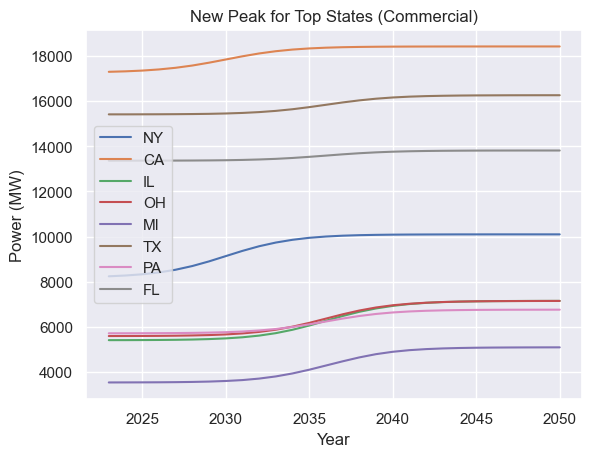

In [21]:
for state in com_states:
    plt.plot(year_range, state_summary_list[state]["New Peak"], label=state)
plt.title(f"New Peak for Top States (Commercial)")   
plt.ylabel("Power (MW)")
plt.xlabel("Year")
plt.legend()

if save_plots:
    plt.savefig("com_new_peak_states.pdf", dpi=150)

plt.show()
    

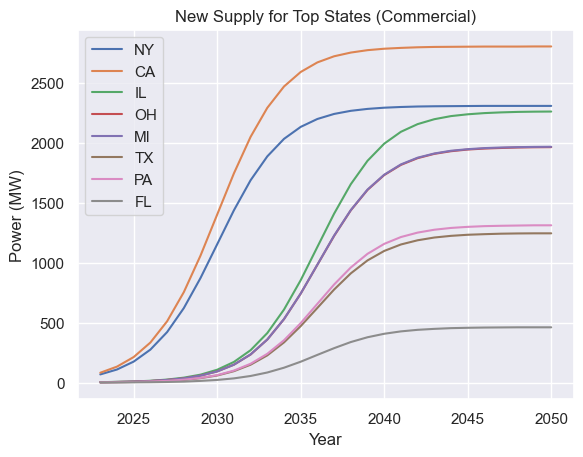

In [22]:
for state in com_states:
    plt.plot(year_range, state_summary_list[state]["New Supply"], label=state)
plt.title(f"New Supply for Top States (Commercial)")   
plt.ylabel("Power (MW)")
plt.xlabel("Year")
plt.legend()

if save_plots:
    plt.savefig("com_new_supply_states.pdf", dpi=150)
    
plt.show()
    

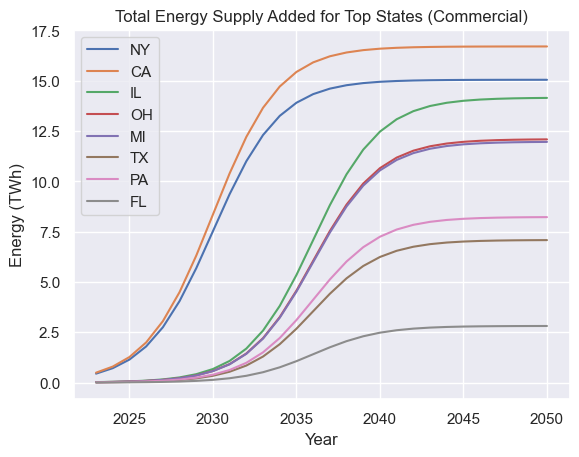

In [23]:
for state in com_states:
    plt.plot(year_range, state_summary_list[state]["Total Energy Added"], label=state)
plt.title(f"Total Energy Supply Added for Top States (Commercial)")   
plt.ylabel("Energy (TWh)")
plt.xlabel("Year")
plt.legend()

if save_plots:
    plt.savefig("com_energy_supply_states.pdf", dpi=150)
    
plt.show()